## Inference using the trained model

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
import math
import json

from IPython.display import Image, display
import random
import jieba

import numpy as np
import tensorflow as tf


import config
from im2txt_model import Im2TxtModel
import inference_wrapper
from inference_utils import caption_generator
from inference_utils import vocabulary

In [2]:
checkpoint_path="../model/semantic_attention_model_join/model.ckpt-122536"
#vocab_file="../data/word_counts.txt"
#attributes_file="../data/attributes.txt"
data_path="../data/"
# dev set
devset_path = os.path.join(data_path, "ai_challenger_caption_validation_20170910")
dev_image_path = os.path.join(devset_path, "caption_validation_images_20170910")
dev_annotation_path = os.path.join(devset_path, "caption_validation_annotations_20170910.json")

In [3]:
FLAGS = tf.flags.FLAGS
tf.flags.DEFINE_string("vocab_file", "../data/word_counts.txt", "Text file containing the vocabulary.")
tf.flags.DEFINE_string("attributes_file", "../data/attributes.txt", "Text file containing the attributes.")


In [18]:
FLAGS.model = "SemanticAttentionModel"
FLAGS.attributes_top_k = 15

In [21]:
# load model
g = tf.Graph()
with g.as_default():
    tf.logging.info("Building model.")
    model = Im2TxtModel(mode="inference")
    model.build()
    saver = tf.train.Saver()
    if tf.gfile.IsDirectory(checkpoint_path):
      checkpoint_path = tf.train.latest_checkpoint(checkpoint_path)
      if not checkpoint_path:
        raise ValueError("No checkpoint file found in: %s" % checkpoint_path)

    def restore_fn(sess):
      tf.logging.info("Loading model from checkpoint: %s", checkpoint_path)
      saver.restore(sess, checkpoint_path)
      tf.logging.info("Successfully loaded checkpoint: %s",
                      os.path.basename(checkpoint_path))
    g.finalize()

INFO:tensorflow:Building model.
[1, 8, 8, 2048]


In [22]:
sess = tf.Session(graph=g)
restore_fn(sess)

INFO:tensorflow:Loading model from checkpoint: ../model/semantic_attention_model_join/model.ckpt-122536
INFO:tensorflow:Restoring parameters from ../model/semantic_attention_model_join/model.ckpt-122536
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-122536


In [7]:
vocab = vocabulary.Vocabulary(FLAGS.vocab_file)

INFO:tensorflow:Initializing vocabulary from file: ../data/word_counts.txt
INFO:tensorflow:Created vocabulary with 8562 words


In [8]:
def show_example(example, image_path):
    image_id = example['image_id']
    caption = example['caption']
    im = Image(filename=os.path.join(image_path, image_id)) 
    display(im)
    for c in caption:
        c = c.strip().strip(u"。").replace('\n', '')
        seg_list = jieba.cut(c, cut_all=False)
        print ' '.join(seg_list)
    #return image_id, caption

In [9]:
# read dev data
input = open(dev_annotation_path,'r')
dev_examples = json.load(input)
input.close()
dev_size = len(dev_examples)

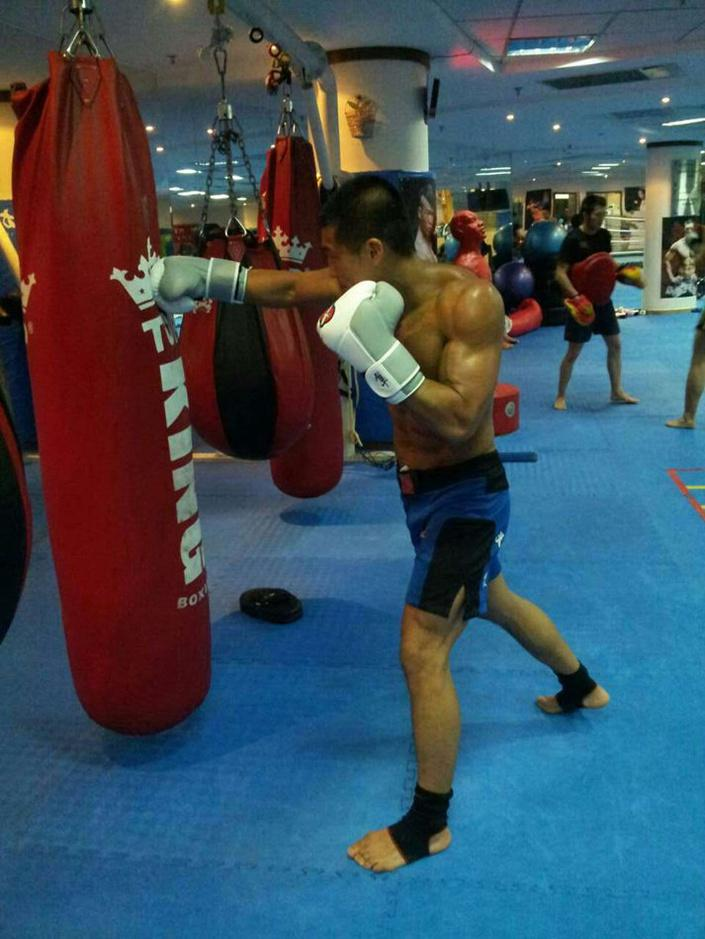

屋子里 一个 人 旁边 有 一个 戴着 拳套 的 男人 在 练 拳击
一个 人 的 旁边 有 一个 穿着 短裤 的 男人 在 健身房 里练 拳击
健身房 里 一个 人 旁边 有 一个 光 着 上身 的 男人 在 打拳击
一个 人 的 旁边 有 一个 穿着 短裤 的 男人 在 健身 馆里 打拳击
一个 人 的 旁边 有 一个 赤裸 着 上身 的 男人 在 干净 的 健身房 里 打拳击
女人 拳击 拳套 男人 戴着 健身房 穿着 打拳击 手套 人 双手 打 练 右手 上衣
[ 0.71260345  0.67412812  0.46680701  0.44274071  0.31684646  0.25489926
  0.23783924  0.22749631  0.15145497  0.15127288  0.12200594  0.09962918
  0.09803154  0.08644968  0.08073045]
[342  15   9  11   8  29   0  10   4  71   2  -1  -1]
健身房 里 有 两个 穿着 运动服 的 女人 在 表演
[342  15   9  11   8  29   0  10   4 170   2  -1  -1]
健身房 里 有 两个 穿着 运动服 的 女人 在 跳舞
[342  15   9   3   8  57  36   0  10   4 157 451   2]
健身房 里 有 一个 穿着 白色 上衣 的 女人 在 做 瑜伽


In [29]:
# run a random image
index = int(random.random() * dev_size)
show_example(dev_examples[index], dev_image_path)
filename = os.path.join(dev_image_path, dev_examples[index]['image_id'])
f = tf.gfile.GFile(filename, "r")
image=f.read()

predicted_ids, scores, top_n_attributes = sess.run(
        [model.predicted_ids, model.scores, model.top_n_attributes],
        feed_dict={"image_feed:0": image})

predicted_ids = np.transpose(predicted_ids, (0,2,1))
scores = np.transpose(scores, (0,2,1))
attr_probs, attr_ids = top_n_attributes
attributes = [vocab.id_to_word(w) for w in attr_ids[0]]
print(" ".join(attributes))
print(attr_probs[0])
#print(top_n_attributes)
for caption in predicted_ids[0]:
    print(caption)
    caption = [id for id in caption if id >= 0 and id != FLAGS.end_token]
    sent = [vocab.id_to_word(w) for w in caption]
    print(" ".join(sent))


